CONDUCTOR MISALIGNMENT PREDICTION

In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime
    
# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
# Train-test split
from sklearn.model_selection import train_test_split


# Hyperparameter tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


# Metrics

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

# Additionals

from pprint import pprint
from math import sqrt

In [193]:
df = pd.read_csv('Data.csv')

df.head()

,S/N,Type/Grade,OD (in),ID (in),BPF,Refusal Depth (ft),Days,Deg. Misalign,Wt (ppf),Grade,Ys (psi),Terrain,Hammer Type
0,1,X56 weld-on,24,22.5,156,399,3,2.0,186,X56,56565,Land,Diesel
1,2,X52 weld-on,30,28.0,168,353,3,2.5,310,X52,52214,Land,Diesel
2,3,X52 weld-on,30,28.0,98,358,3,0.5,310,X52,52214,Land,Diesel
3,4,X56 weld-on,24,22.5,135,362,2,1.5,186,X56,56565,Swamp,Diesel
4,5,X56 weld-on,24,22.5,68,369,2,4.5,186,X56,56565,Swamp,Hydraulic


In [194]:
df = df.drop(['S/N','Type/Grade','Grade','Terrain', 'Hammer Type'], axis=1)
print(df.head())


   OD (in)  ID (in)  BPF  Refusal Depth (ft)  Days  Deg. Misalign  Wt (ppf)  \
0       24     22.5  156                 399     3            2.0       186   
1       30     28.0  168                 353     3            2.5       310   
2       30     28.0   98                 358     3            0.5       310   
3       24     22.5  135                 362     2            1.5       186   
4       24     22.5   68                 369     2            4.5       186   

   Ys (psi)  
0     56565  
1     52214  
2     52214  
3     56565  
4     56565  


In [195]:
print(f"Original number of rows: {len(df)}")

Original number of rows: 20


In [196]:
df = df.sample(n=200, replace=True)

In [201]:
print(f"Number of rows after bootstrapping: {len(df)}")

Number of rows after bootstrapping: 200


In [202]:
df.to_csv('bootstrapped_data.csv', index=False)

In [203]:
print("Bootstrapped data saved to 'bootstrapped_data.csv'")

Bootstrapped data saved to 'bootstrapped_data.csv'


In [207]:
df.head()

,OD (in),ID (in),BPF,Refusal Depth (ft),Days,Deg. Misalign,Wt (ppf),Ys (psi)
9,30,28.0,250,275,2,0.0,310,52214
17,30,28.0,120,307,3,0.0,310,56565
16,30,28.0,120,190,2,0.0,310,52214
17,30,28.0,120,307,3,0.0,310,56565
9,30,28.0,250,275,2,0.0,310,52214


In [209]:
scaler_all_data = MinMaxScaler()
data_scaled = scaler_all_data.fit_transform(df)
df_data_scaled=pd.DataFrame(data_scaled)
df_data_scaled.head(5)

,0,1,2,3,4,5,6,7
0,0.5,0.478261,1.000000,0.336735,0.0,0.0,0.659574,0.0
1,0.5,0.478261,0.329897,0.445578,0.5,0.0,0.659574,1.0
2,0.5,0.478261,0.329897,0.047619,0.0,0.0,0.659574,0.0
3,0.5,0.478261,0.329897,0.445578,0.5,0.0,0.659574,1.0
4,0.5,0.478261,1.000000,0.336735,0.0,0.0,0.659574,0.0


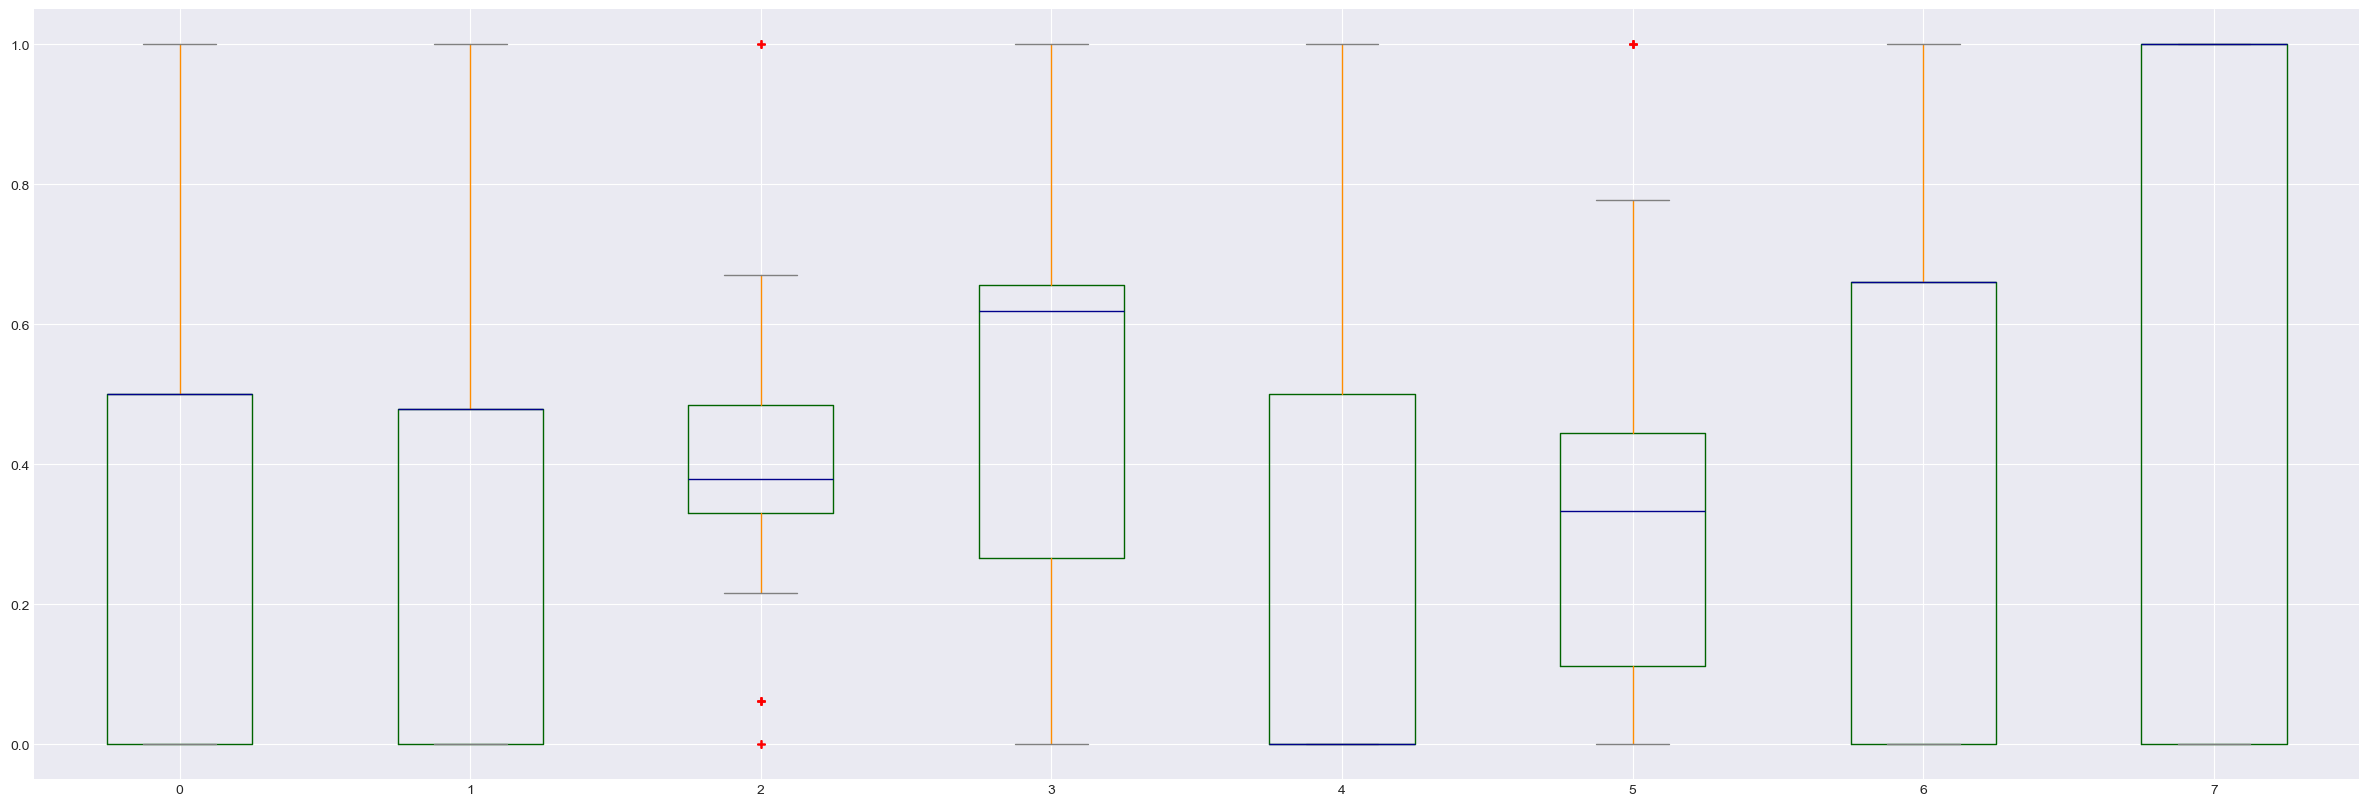

In [211]:
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}
bp_scaled_all_data = df_data_scaled.plot.box(color=color, sym='r+' ,figsize=(30,10))

In [212]:
print(df.columns)

Index(['OD (in)', 'ID (in)', 'BPF', 'Refusal Depth (ft)', 'Days',
       'Deg. Misalign', 'Wt (ppf)', 'Ys (psi)'],
      dtype='object')


In [213]:
# List of columns to analyze
columns = ['OD (in)', 'ID (in)', 'BPF', 'Refusal Depth (ft)', 'Wt (ppf)', 'Ys (psi)']

# Calculate mean, variance, and standard deviation
for col in columns:
    if col in df.columns:
        mean = df[col].mean()
        variance = df[col].var()
        std_deviation = df[col].std()
        print(f"Column: {col}")
        print(f"Mean: {mean}")
        print(f"Variance: {variance}")
        print(f"Standard Deviation: {std_deviation}\n")
    else:
        print(f"Column '{col}' not found in DataFrame.\n")

Column: OD (in)
Mean: 27.84
Variance: 10.868743718592963
Standard Deviation: 3.2967777781635452

Column: ID (in)
Mean: 26.0375
Variance: 9.404365577889463
Standard Deviation: 3.066653807962265

Column: BPF
Mean: 132.93
Variance: 1398.889547738693
Standard Deviation: 37.40173188154117

Column: Refusal Depth (ft)
Mean: 327.085
Variance: 6334.590728643218
Standard Deviation: 79.59014215745074

Column: Wt (ppf)
Mean: 263.26
Variance: 4052.514974874371
Standard Deviation: 63.65936674892683

Column: Ys (psi)
Mean: 54715.825
Variance: 4649560.044597975
Standard Deviation: 2156.2838506555613



In [214]:
parameters = df[['OD (in)', 'ID (in)', 'BPF', 'Refusal Depth (ft)', 'Wt (ppf)', 'Ys (psi)']]

# Initialize dictionaries to store statistics
stats_data = {
    'Column': [],
    'Mean': [],
    'Variance': [],
    'Standard Deviation': []
}

# Calculate the mean, variance, and standard deviation for each column
for col in parameters.columns:
    stats_data['Column'].append(col)
    stats_data['Mean'].append(parameters[col].mean())
    stats_data['Variance'].append(parameters[col].var())
    stats_data['Standard Deviation'].append(parameters[col].std())

# Convert the dictionary into a pandas DataFrame for a table-like display
stats_df = pd.DataFrame(stats_data)

# Display the table
print(stats_df)

               Column        Mean      Variance  Standard Deviation
0             OD (in)     27.8400  1.086874e+01            3.296778
1             ID (in)     26.0375  9.404366e+00            3.066654
2                 BPF    132.9300  1.398890e+03           37.401732
3  Refusal Depth (ft)    327.0850  6.334591e+03           79.590142
4            Wt (ppf)    263.2600  4.052515e+03           63.659367
5            Ys (psi)  54715.8250  4.649560e+06         2156.283851


Pearson Correlation Matrix:
                     OD (in)   ID (in)       BPF  Refusal Depth (ft)  \
OD (in)             1.000000  0.999650  0.031533           -0.443300   
ID (in)             0.999650  1.000000  0.029859           -0.445721   
BPF                 0.031533  0.029859  1.000000           -0.009770   
Refusal Depth (ft) -0.443300 -0.445721 -0.009770            1.000000   
Days                0.242297  0.234576 -0.081611            0.622016   
Deg. Misalign       0.017245  0.023415 -0.257087            0.335521   
Wt (ppf)            0.988220  0.983823  0.040779           -0.423184   
Ys (psi)           -0.564694 -0.551561 -0.137437            0.289100   

                        Days  Deg. Misalign  Wt (ppf)  Ys (psi)  
OD (in)             0.242297       0.017245  0.988220 -0.564694  
ID (in)             0.234576       0.023415  0.983823 -0.551561  
BPF                -0.081611      -0.257087  0.040779 -0.137437  
Refusal Depth (ft)  0.622016       0.335521 -0.423184  0.28

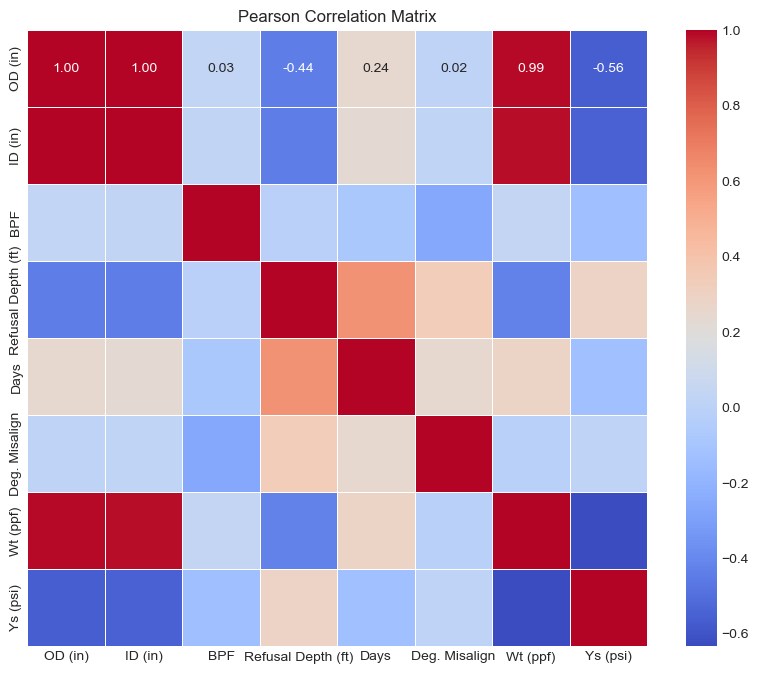

In [218]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the Pearson correlation matrix
correlation_matrix = df.corr(method='pearson')

# Print the correlation matrix
print("Pearson Correlation Matrix:")
print(correlation_matrix)

# Optional: Visualize the correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Pearson Correlation Matrix')
plt.show()

In [220]:
# pairs = [
#     ('Deg. Misalign', 'ID (in)'),
#     ('Deg. Misalign', 'BPF'),
#     ('Deg. Misalign', 'Refusal Depth (ft)'),
#     ('Deg. Misalign', 'Wt (ppf)'),
#     ('Deg. Misalign', 'Ys (psi)'),
#     ('Deg. Misalign', 'OD (in)')
#     # Add more pairs as needed
# ]

# # Create scatter plots for each pair
# for x_col, y_col in pairs:
#     plt.figure(figsize=(10, 6))
#     plt.scatter(df[x_col], df[y_col], alpha=0.7, edgecolors='w', s=100)
#     plt.title(f'Scatter Plot: {x_col} vs {y_col}')
#     plt.xlabel(x_col)
#     plt.ylabel(y_col)
#     plt.grid(True)
#     plt.show()

In [221]:
X = df.filter(['OD (in)','ID (in)','BPF','Refusal Depth (ft)', 'Wt (ppf)', 'Ys (psi)'])
Y = df[['Deg. Misalign']]
Y= np.ravel(Y)
print('Features shape:', X.shape)
print('Target shape', Y.shape)

Features shape: (200, 6)
Target shape (200,)


In [223]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'SVR': SVR()
}

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle = True)


Time=df.iloc[:,0]
Time_train, Time_test = train_test_split(Time, test_size=0.3, random_state=42)

In [228]:
# Cross-validate each model and store the results
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    results[model_name] = np.mean(np.sqrt(-scores))  # Use RMSE for easier interpretation
    print(f"{model_name}: RMSE = {results[model_name]:.4f} (+/- {np.std(np.sqrt(-scores)):.4f})")

# Select the best model based on cross-validation results
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name} with RMSE of {results[best_model_name]:.4f}")

# Define hyperparameter grids for fine-tuning
param_grid = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
}

# Perform Grid Search for the best model (if it has hyperparameters to tune)
if best_model_name in param_grid:
    grid_search = GridSearchCV(best_model, param_grid[best_model_name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {best_model_name}: {grid_search.best_params_}")

# Evaluate the final tuned model on the test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE of the best model on the test set: {rmse:.4f}")

Linear Regression: RMSE = 1.0370 (+/- 0.0780)
Decision Tree: RMSE = 0.0000 (+/- 0.0000)
Random Forest: RMSE = 0.0616 (+/- 0.0302)
SVR: RMSE = 1.2407 (+/- 0.1405)
Best Model: Decision Tree with RMSE of 0.0000
Final RMSE of the best model on the test set: 0.0000


In [231]:
rf =RandomForestRegressor(criterion='squared_error', random_state=0).fit(X_train, y_train) #Random_state is the seed used by the random number generator
predictions_rf = rf.predict(X_test)

# Metrics
print('Model score:',              round(rf.score(X_test, y_test),2))
print('Mean absolute error:',      round(mean_absolute_error(y_test, predictions_rf),2))
print('Root mean squared error:',  round(sqrt(mean_squared_error(y_test, predictions_rf)),2))
print('R2:',                       round(r2_score(y_test, predictions_rf),2))

Model score: 1.0
Mean absolute error: 0.01
Root mean squared error: 0.02
R2: 1.0


In [233]:
# We require to import the time library for the run time evaluation
import time

# All features training and testing time
all_features_time = []

# We decide to do 10 iterations and take average for all features
for _ in range(10):
    start_time = time.time()
    rf.fit(X_train, y_train)
    all_features_predictions = rf.predict(X_test)
    end_time = time.time()
    all_features_time.append(end_time - start_time)

all_features_time = np.mean(all_features_time)
print('All features total training and testing time:', round(all_features_time, 2), 'seconds.')

All features total training and testing time: 0.29 seconds.


In [235]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [237]:
# Definition of specific parameters for Random forest 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 2000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 30, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [4, 30, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 3, 4, 5, 10],
 'n_estimators': [2,
                  107,
                  212,
                  317,
                  422,
                  527,
                  632,
                  738,
                  843,
                  948,
                  1053,
                  1158,
                  1263,
                  1369,
                  1474,
                  1579,
                  1684,
                  1789,
                  1894,
                  2000]}


In [239]:
rf = RandomForestRegressor(random_state = 42)

# Use the random grid to search for best hyperparameters
# Random search of parameters, using 3 fold cross validation, 
# search across different combinations.
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter = 15, scoring='neg_mean_absolute_error',  cv = 3, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train);

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [240]:
rf_random.best_params_

{'n_estimators': 1894,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_depth': None,
 'bootstrap': False}

In [247]:
best_random = rf_random.best_estimator_.fit(X_train, y_train)
predictions_best_random_test = best_random.predict(X_test)
predictions_best_random_train = best_random.predict(X_train)

print('Model score:', round(best_random.score(X_test, y_test),2))
print('Mean absolute error:', round(mean_absolute_error(y_test, predictions_best_random_test),2))
print('Root mean squared error:', round(sqrt(mean_squared_error(y_test, predictions_best_random_test)),2))
print('R2:', round(r2_score(y_test, predictions_best_random_test),2))

r2_rf=r2_score(y_test, predictions_best_random_test)
Mean_absolute_error_rf=mean_absolute_error(y_test, predictions_best_random_test)
Root_mean_squared_error_rf=sqrt(mean_squared_error(y_test, predictions_best_random_test))

Model score: 1.0
Mean absolute error: 0.0
Root mean squared error: 0.0
R2: 1.0


In [242]:
# Metrics for training data
print('Training Model score:', round(best_random.score(X_train, y_train), 2))
print('Training Mean absolute error:', round(mean_absolute_error(y_train, predictions_best_random_train), 2))
print('Training Root mean squared error:', round(sqrt(mean_squared_error(y_train, predictions_best_random_train)), 2))
print('Training R2:', round(r2_score(y_train, predictions_best_random_train), 2))

r2_rf_train = r2_score(y_train, predictions_best_random_train)
Mean_absolute_error_rf_train = mean_absolute_error(y_train, predictions_best_random_train)
Root_mean_squared_error_rf_train = sqrt(mean_squared_error(y_train, predictions_best_random_train))

Training Model score: 1.0
Training Mean absolute error: 0.0
Training Root mean squared error: 0.0
Training R2: 1.0


In [249]:
result_df = result_df = pd.DataFrame({'Deg. Misalign (Actual)': y_test, 'Deg. Misalign (Predicted)': predictions_best_random_test})
print(result_df)

    Deg. Misalign (Actual)  Deg. Misalign (Predicted)
0                      0.5                        0.5
1                      3.5                        3.5
2                      2.5                        2.5
3                      0.5                        0.5
4                      0.5                        0.5
5                      2.0                        2.0
6                      0.5                        0.5
7                      0.5                        0.5
8                      0.5                        0.5
9                      0.0                        0.0
10                     0.5                        0.5
11                     4.5                        4.5
12                     0.5                        0.5
13                     2.0                        2.0
14                     0.5                        0.5
15                     2.0                        2.0
16                     2.0                        2.0
17                     3.5  

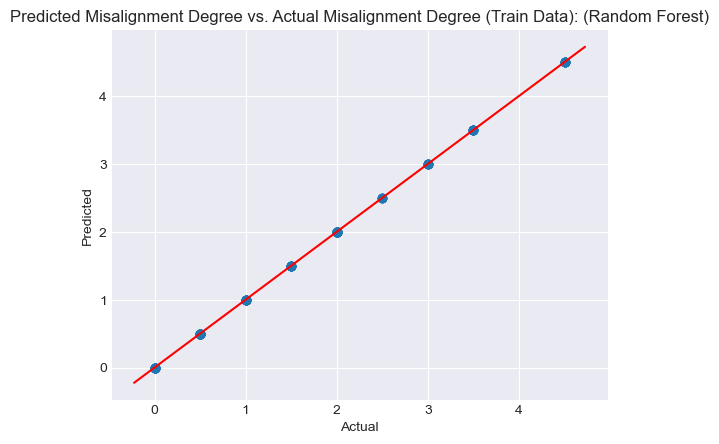

In [251]:
from scipy import stats
import statsmodels as sm

X_train_np = np.array(X_train)
y_np = np.array(y_train)

def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-',color='red')

#predict y values for training data
y_hat = predictions_best_random_train 

#plot predicted vs actual
plt.plot(y_hat,y_np,'o')
plt.xlabel('Actual'),#color='white')
plt.ylabel('Predicted')#,color='white')
plt.title('Predicted Misalignment Degree vs. Actual Misalignment Degree (Train Data): (Random Forest)')#,color='white')
abline(1,0)
plt.show()

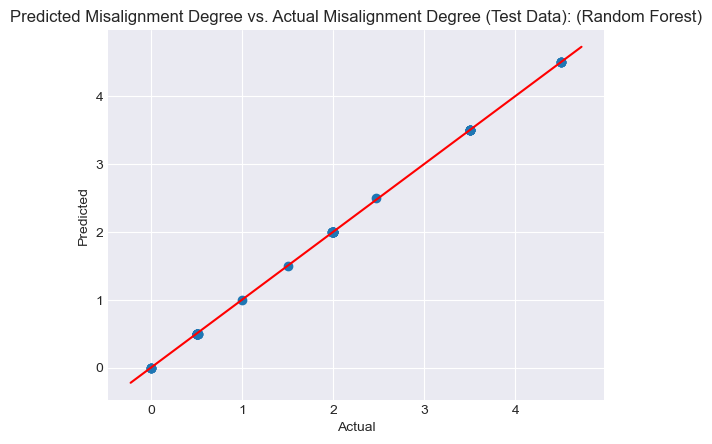

In [253]:
rf.fit(X_train, y_train)
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-',color='red')

# Predict y values for test data
y_hat_test = rf.predict(X_test)
y_test_np = np.array(y_test).ravel()  # Ensure y_test is in the same format as y_hat_test

# Plot predicted vs actual for test data
plt.plot(y_hat_test, y_test_np, 'o')
plt.xlabel('Actual'),#color='white')
plt.ylabel('Predicted')#,color='white')
plt.title('Predicted Misalignment Degree vs. Actual Misalignment Degree (Test Data): (Random Forest)'),#color='white')
abline(1, 0)
plt.show()

In [257]:
# Get feature importances
feature_importances = best_random.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
print(feature_importance_df)

              Feature  Importance
3  Refusal Depth (ft)    0.459402
2                 BPF    0.406166
5            Ys (psi)    0.080174
4            Wt (ppf)    0.018606
0             OD (in)    0.018300
1             ID (in)    0.017352


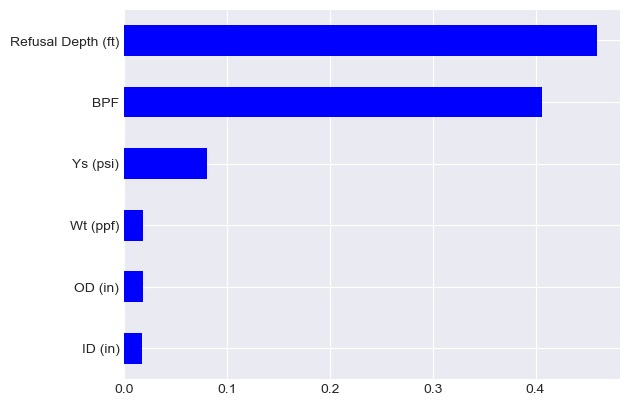

In [261]:
importances_rf= pd.Series(best_random.feature_importances_, index = X.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='blue'); plt.show()

LINEAR REGRESSION

In [266]:
# Features and target
X = df.drop('Deg. Misalign', axis=1)  # Drop the target column to get the features
y = df['Deg. Misalign']  # Target variable

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared, to check how well the model explains the variability

# Print the results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Optional: Print model coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

Mean Squared Error: 1.3216553442634011
R-squared: 0.35876019988736496
                    Coefficient
OD (in)                0.491885
ID (in)                0.536024
BPF                   -0.007934
Refusal Depth (ft)     0.008879
Days                  -0.204692
Wt (ppf)              -0.049946
Ys (psi)              -0.000200


In [268]:
model_score = model.score(X_test, y_test)
print(f"Model Score (R-squared): {model_score}")

Model Score (R-squared): 0.35876019988736496


In [276]:

X = df.drop('Deg. Misalign', axis=1)  # Drop the target column to get the features
y = df['Deg. Misalign']  # Target variable

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree model
model = DecisionTreeRegressor(random_state=42)  # Use DecisionTreeClassifier() for classification

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Print the results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Print model score (R-squared)
model_score = model.score(X_test, y_test)
print(f"Model Score (R-squared): {model_score}")



Mean Squared Error: 0.0
R-squared: 1.0
Model Score (R-squared): 1.0


In [280]:
X = df.drop('Deg. Misalign', axis=1)  # Drop the target column to get the features
y = df['Deg. Misalign']  # Target variable

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVR model
model = SVR(kernel='rbf')  # 'rbf' is the radial basis function kernel, other options are 'linear', 'poly', etc.

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared

# Print the results
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Print model score (R-squared)
model_score = model.score(X_test, y_test)
print(f"Model Score (R-squared): {model_score}")

Mean Squared Error: 2.1910192692631716
R-squared: -0.0630371710472517
Model Score (R-squared): -0.0630371710472517
